In [67]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import GPy
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from anastruct.basic import converge
from anastruct.material.profile import HEA, IPE
from anastruct.fem.system import SystemElements, Vertex
from anastruct.material.units import to_kNm2, to_kN
import anastruct

In [70]:
# anastruct version == anastruct==1.1.0a1

# Bayesian Optimization for water accumulation analysis

See these posts:

* [water accumulation](https://www.ritchievink.com/blog/2017/08/23/a-nonlinear-water-accumulation-analysis-in-python/)
* [bayesian optimization](https://www.ritchievink.com/blog/2019/08/25/algorithm-breakdown-bayesian-optimization/)

For optimization purposes we make the `structure` function take the following inputs:

* mp_span_1
* mp_span_2
* mp_span_3
* k1
* k2

These parameters will be optimized within the following boundaries:

```python
{'mp_span_1': {'range': [70, 91], 'type': 'float'},
 'mp_span_2': {'range': [240, 312], 'type': 'float'},
 'mp_span_3': {'range': [25, 32], 'type': 'float'},
 'k1': {'range': [2000, 2600], 'type': 'float'},
 'k2': {'range': [3000, 3900], 'type': 'float'}}
```

The stiffness of the rotation is assumed to be linearly increasing with `mp`. See the `structure` function;

```python
    first = dict(spring={1: 9e3 / 70 * mp_span_1}, mp={1: mp_span_1})
```


In [56]:

# constants
E = 2.1e5 / 1.3
b = 5 * 1.09
q_water = 10

# axes height levels
h_1 = 0
h_2 = 0.258
h_3 = 0.046
h_4 = 0.274
h_5 = 0.032
h_6 = 0.15

# beam spans
span_1 = span_2 = 21.9
span_3 = 8.9

# Vertices at the axes
p1 = Vertex(0, h_1)
p2 = Vertex(span_1 * 0.5, h_2)
p3 = Vertex(span_1, h_3)
p4 = Vertex(span_1 + span_2 * 0.5, h_4)
p5 = Vertex(span_1 + span_2, h_5)
p6 = Vertex(span_1 + span_2 + span_3, h_6)


def structure(
    mp_span_1=70,
    mp_span_2=240,
    mp_span_3=25,
    k1=2e3,
    k2=3e3,
):
    """
    Build the structure from left to right, starting at axis 1.

    variables:
    EA = Young's modulus * Area
    EI = Young's modulus * moment of Inertia
    g = Weight [kN/ m]
    elements = reference of the element id's that were created
    dl = c.t.c distance different nodes.
    """

    dl = 0.2

    ## SPAN 1 AND 2

    # The elements between axis 1 and 3 are an IPE 450 member.
    EA = to_kN(E * IPE[450]["A"])  # Y
    EI = to_kNm2(E * IPE[450]["Iy"])
    g = IPE[450]["G"] / 100

    # New system.
    ss = SystemElements(mesh=3)

    # span 1
    first = dict(spring={1: 9e3 / 70 * mp_span_1}, mp={1: mp_span_1})

    elements = ss.add_multiple_elements(
        location=[p1, p2], dl=dl, first=first, EA=EA, EI=EI, g=g
    )
    elements += ss.add_multiple_elements(location=p3, dl=dl, EA=EA, EI=EI, g=g)

    # span 2
    first = dict(spring={1: 40e3 / 240 * mp_span_2}, mp={1: mp_span_2})
    elements += ss.add_multiple_elements(
        location=p4, dl=dl, first=first, EA=EA, EI=EI, g=g
    )
    elements += ss.add_multiple_elements(location=p5, dl=dl, EA=EA, EI=EI, g=g)

    ## SPAN 3

    # span 3
    # different IPE
    g = IPE[240]["G"] / 100
    EA = to_kN(E * IPE[240]["A"])
    EI = to_kNm2(E * IPE[240]["Iy"])
    first = dict(spring={1: 15e3 / 25 * mp_span_3}, mp={1: mp_span_3})

    elements += ss.add_multiple_elements(
        location=p6, first=first, dl=dl, EA=EA, EI=EI, g=g
    )

    # Add a dead load of -2 kN/m to all elements.
    ss.q_load(-2, elements, direction="y")

    ## COLUMNS

    # column height
    h = 7.2

    # left column
    EA = to_kN(E * IPE[220]["A"])
    EI = to_kNm2(E * HEA[220]["Iy"])
    left = ss.add_element([[0, 0], [0, -h]], EA=EA, EI=EI)

    # right column
    EA = to_kN(E * IPE[180]["A"])
    EI = to_kNm2(E * HEA[180]["Iy"])
    right = ss.add_element([p6, Vertex(p6.x, -h)], EA=EA, EI=EI)

    ## SUPPORTS

    # node ids for the support
    id_left = max(ss.element_map[left].node_map.keys())
    id_top_right = min(ss.element_map[right].node_map.keys())
    id_btm_right = max(ss.element_map[right].node_map.keys())

    # Add supports. The location of the supports is defined with the nodes id.
    ss.add_support_hinged((id_left, id_btm_right))

    # Retrieve the node ids at axis 2 and 3
    id_p3 = ss.find_node_id(p3)
    id_p5 = ss.find_node_id(p5)

    ss.add_support_roll(id_top_right, direction=1)

    # Add translational spring supports at axes 2 and 3
    ss.add_support_spring(id_p3, translation=2, k=k1, roll=True)
    ss.add_support_spring(id_p5, translation=2, k=k2, roll=True)
    return ss


def water_load(ss, water_height, deflection=None):
    """
    :param ss: (SystemElements) object.
    :param water_height: (flt) Water level.
    :param deflection: (array) Computed deflection.
    :return (flt) The cubic meters of water on the structure
    """

    # The horizontal distance between the nodes.
    dl = np.diff(ss.nodes_range("x"))

    if deflection is None:
        deflection = np.zeros(len(ss.node_map))

    # Height of the nodes
    y = np.array(ss.nodes_range("y"))

    # An array with point loads.
    # cubic meters * weight water
    force_water = (water_height - y[:-3] - deflection[:-3]) * q_water * b * dl[:-2]

    cubics = 0
    n = force_water.shape[0]
    for k in ss.node_map:
        if k > n:
            break
        point_load = force_water[k - 1]

        if point_load > 0:
            ss.point_load(k, Fx=0, Fy=-point_load)
            cubics += point_load / q_water

    return cubics


def det_water_height(c, deflection=None, hyperparams={}):
    """
    :param c: (flt) Cubic meters.
    :param deflection: (array) Node deflection values.
    :return (SystemElement, flt) The structure and the redistributed water level is returned.
    """
    wh = 0.1

    while True:
        ss = structure(**hyperparams)
        cubics = water_load(ss, wh, deflection)

        factor = converge(cubics, c)
        if 0.9999 <= factor <= 1.0001:
            return ss, wh

        wh *= factor


def determine_max_water_cubic(hyper_params, return_ss=False):
    cubics = [0]
    water_heights = [0]

    deflection = None
    max_water_level = 0

    # Iterate from 8 m3 to 15 m3 of water.
    for cubic in reversed(
        (14 - np.logspace(0, 1, 35)[:-10])
    ):  # This loop computes the results per m3 of storaged water.
        wh = 0.05
        lastwh = 0.2

        print(f"Starting analysis of {cubic} m3")

        c = 1
        for _ in range(100):  # This loop redistributes the water until the water level converges.

            # redistribute the water
            ss, wh = det_water_height(cubic, deflection, hyper_params)

            # Do a non linear calculation!!
            ss.solve(max_iter=100, verbosity=1)
            deflection = ss.get_node_result_range("uy")

            # Some breaking conditions
            if min(deflection) < -1:
                print(min(deflection), "Breaking due to exceeding max deflection")
                break
            if 0.9999 < lastwh / wh < 1.001:
                print(f"Convergence in {c} iterations.")
                cubics.append(cubic)
                water_heights.append(wh)
                break

            lastwh = wh
            c += 1

        if wh > max_water_level:
            max_water_level = wh
        else:
            print("Breaking. Water level isn't rising.")
            break
    
    if return_ss:
        return ss, cubics, water_heights
    
    return max_water_level


In [14]:

def select_hyperparams_random(param_ranges):
    """
    Select hyperparameters at random.
    
    Parameters
    ----------
    param_ranges : dict
        Named parameter ranges.

        Example:
        
        {
            'foo': {
                'range': [1, 10],
                'type': 'float'
            }
            'bar': {
                'range': [10, 1000],
                'type': 'int'
            }
        }

    Returns
    -------
    selection : dict
        Randomly selected hyperparameters within given boundaries.
        
        Example:
        {'foo': 4.213, 'bar': 935}

    """
    selection = {}
    for k in param_ranges:
        val = np.random.choice(
            np.linspace(*param_ranges[k]['range'], num=100)
        )

        dtype = param_ranges[k]['type']
        if dtype is 'int':
            val = int(val)
        selection[k] = val
    return selection


def expected_improvement(f, y_current, x_proposed):
    """
    Return E(max(f_proposed - f_current), 0)

    Parameters
    ----------

    f : GP predict function
    y_current : float
        Current best evaluation f(x+)
    x_proposed : np.array
        Proposal parameters. Shape: (1, 1)

    Returns
    -------
    expected_improvement : float
        E(max(f_proposed - f_current), 0)
    """
    mu, var = f(x_proposed)
    std = var ** 0.5
    delta = mu - y_current

    # x / inf = 0
    std[std == 0] = np.inf
    z = delta / std
    unit_norm = stats.norm()
    return delta * unit_norm.cdf(z) + std * unit_norm.pdf(z)


In [15]:
class BayesOpt:
    def __init__(
        self, param_ranges, f, random_trials=5, optimization_trials=20, kernel=None
    ):
        """
        Parameters
        ----------

        param_ranges : dict
        f : function
            black box function to evaluate
        random_trials : int
            Number of random trials to run before optimization starts
        optimization_trials : int
            Number of optimization trials to run.
            Together with the random_trials this is the total budget
        kernel: GPy.kern.src.kern.Kern
            GPy kernel for the Gaussian Process.
            If None given, RBF kernel is used
        """
        self.param_ranges = param_ranges
        self.f = f
        self.random_trials = random_trials
        self.optimization_trials = optimization_trials
        self.n_trials = random_trials + optimization_trials
        self.x = np.zeros((self.n_trials, len(param_ranges)))
        self.y = np.zeros((self.n_trials, 1))

        if kernel is None:
            self.kernel = GPy.kern.RBF(
                input_dim=self.x.shape[1], variance=1, lengthscale=1
            )
        else:
            self.kernel = kernel
        self.gp = None
        self.bounds = np.array([pr["range"] for pr in param_ranges.values()])

    @property
    def best_params(self):
        """
        Select best parameters.

        Returns
        -------
        best_parameters : dict
        """
        return self._prepare_kwargs(self.x[self.y.argmax()])

    def fit(self):
        self._random_search()
        self._bayesian_search()

    def _random_search(self):
        """
        Run the random trials budget
        """
        print(f"Starting {self.random_trials} random trials...")
        for i in tqdm(range(self.random_trials)):
            hp = select_hyperparams_random(self.param_ranges)
            self.x[i] = np.array(list(hp.values()))
            self.y[i] = self.f(hp)
            print(f'HP: {hp}\t y:{self.y[i]}')

    def _bayesian_search(self):
        """
        Run the Bayesian Optimization budget
        """
        print(f"Starting {self.optimization_trials} optimization trials...")
        for i in tqdm(
            range(self.random_trials, self.random_trials + self.optimization_trials)
        ):
            self.x[i], self.y[i] = self._single_iter()

    def _single_iter(self, x=None):
        """
        Fit a GP and retrieve and evaluate a new
        parameter proposal.

        Returns
        -------
        out : tuple[np.array[flt], np.array[flt]]
            (x, f(x))

        """
        self._fit_gp()
        if x is None:
            x = self._new_proposal()
        y = self.f(self._prepare_kwargs(x))
        print(f'HP: {self._prepare_kwargs(x)}\t y:{y}')
        return x, y

    def _fit_gp(self, noise_var=0):
        """
        Fit a GP on the currently observed data points.

        Parameters
        ----------
        noise_var : flt
            GPY argmument noise_var
        """
        mask = self.x.sum(axis=1) != 0
        self.gp = GPy.models.GPRegression(
            self.x[mask],
            self.y[mask],
            normalizer=True,
            kernel=self.kernel,
            noise_var=noise_var,
        )
        self.gp.optimize()

    def _new_proposal(self, n=25):
        """
        Get a new parameter proposal by maximizing
        the acquisition function.

        Parameters
        ----------
        n : int
            Number of retries.
            Each new retry the optimization is
            started in another parameter location.
            This improves the chance of finding a global optimum.

        Returns
        -------
        proposal : dict
            Example:
           {'foo': 4.213, 'bar': 935}
        """

        def f(x):
            return -expected_improvement(
                f=self.gp.predict, y_current=self.y.max(), x_proposed=x[None, :]
            )

        x0 = np.random.uniform(
            low=self.bounds[:, 0], high=self.bounds[:, 1], size=(n, self.x.shape[1])
        )
        proposal = None
        best_ei = np.inf
        for x0_ in x0:
            res = optimize.minimize(f, x0_, bounds=self.bounds)
            if res.success and res.fun < best_ei:
                best_ei = res.fun
                proposal = res.x
            if np.isnan(res.fun):
                raise ValueError("NaN within bounds")
        return proposal

    def _prepare_kwargs(self, x):
        """
        Create a dictionary with named parameters
        and the proper python types.

        Parameters
        ----------
        x : np.array
            Example:
            [4.213, 935.03]

        Returns
        -------
        hyperparameters : dict

            Example:
            {'foo': 4.213, 'bar': 935}
        """
        # create hyper parameter dict
        hp = dict(zip(self.param_ranges.keys(), x))
        # cast values
        for k in self.param_ranges:
            if self.param_ranges[k]["type"] == "int":
                hp[k] = int(hp[k])
            elif self.param_ranges[k]["type"] == "float":
                hp[k] = float(hp[k])
            else:
                raise ValueError("Parameter type not known")
        return hp

In [16]:
maximum_factor = 1.3

param_ranges = {
    'mp_span_1': {
        'range': [70, int(70 * maximum_factor)],
        'type': 'float'
    },
    'mp_span_2': {
        'range': [240, int(240 * maximum_factor)],
        'type': 'float'
    },
    'mp_span_3': {
        'range': [25, int(25 * maximum_factor)],
        'type': 'float'
    },
    'k1': {
        'range': [2000, int(2000 * maximum_factor)],
        'type': 'float'
    },
    'k2': {
        'range': [3000, int(3000 * maximum_factor)],
        'type': 'float'
    }
}

In [ ]:
bo = BayesOpt(param_ranges, 
              determine_max_water_cubic, 
              random_trials=5, 
              optimization_trials=15, 
              kernel=GPy.kern.Matern52(input_dim=3) + GPy.kern.Matern32(input_dim=3))
bo.fit()

# Results

In [50]:
bo.best_params

{'mp_span_1': 79.73448251348799,
 'mp_span_2': 265.11052593961267,
 'mp_span_3': 29.237956757987163,
 'k1': 2570.259044964325,
 'k2': 3443.585144096509}

Text(0.5, 0, 'iterations')

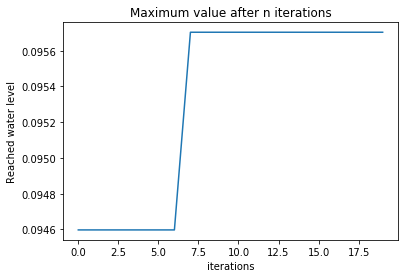

In [51]:
plt.title('Maximum value after n iterations')
plt.plot(np.maximum.accumulate(bo.y))
plt.ylabel('Reached water level')
plt.xlabel('iterations')

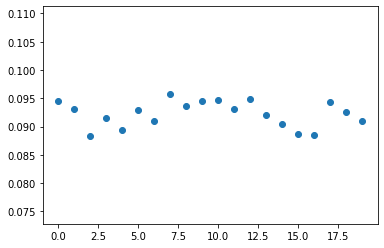

In [53]:
plt.scatter(np.arange(bo.y.shape[0]), bo.y)

In [59]:
ss, cubics, water_heights = determine_max_water_cubic(bo.best_params, return_ss=True)

Starting analysis of 8.919781953086979 m3
Convergence in 5 iterations.
Starting analysis of 9.252438621002577 m3
Convergence in 3 iterations.
Starting analysis of 9.563312669021387 m3
Convergence in 3 iterations.
Starting analysis of 9.85383044020318 m3
Convergence in 3 iterations.
Starting analysis of 10.125324879543868 m3
Convergence in 3 iterations.
Starting analysis of 10.379041649754082 m3
Convergence in 4 iterations.
Starting analysis of 10.616144846571766 m3
Convergence in 39 iterations.
Breaking. Water level isn't rising.


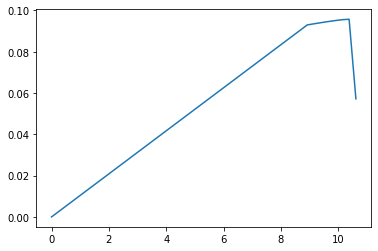

In [62]:
plt.plot(cubics, water_heights)

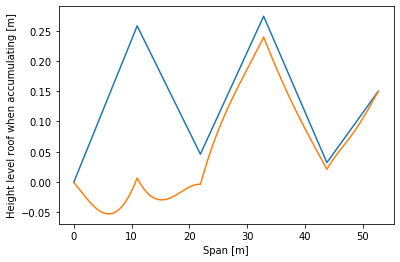

In [63]:
plt.plot(ss.nodes_range('x')[:-2], ss.nodes_range('y')[:-2])
plt.plot(ss.nodes_range('x')[:-2], [a + b for a, b in zip(ss.nodes_range('y')[:-2], ss.get_node_result_range("uy")[:-2])])

plt.ylabel("Height level roof when accumulating [m]")
plt.xlabel("Span [m]")
plt.show()